### Bet Sizing from Predicted Probabilities

$p(x)$는 label $x$가 나타날 확률이라고 표기하자. 두 가지 가능한 출력 $x \in \{-1, 1\}$에 대해 귀무가설 $H_0 : p[x = 1] = \frac{1}{2}$을 검정해 보려고 한다. 검정 통계량 $z = \frac{p[x = 1]  -\frac{1}{2}}{\sqrt{p[x=1](1 - p[x=1])}} = \frac{2p[x = 1] - 1}{2\sqrt{p[x=1](1 - p[x=1])}} \sim Z, z\in \left( -\infty, +\infty \right)$을 계산한다. $Z$는 표준 정규 분포를 나타낸다. 베팅 크기는 $m = 2Z[z] - 1$로 도출하고, $m \in [-1, 1]$이며 $Z[.]$는 $Z$의 누적 분포 함수이다.

가능한 결과의 개수가 2개를 넘을 때에는 OVR 방법을 사용한다. $X = \{-1, \dots, 0, \dots, 1\}$가 베팅 크기에 연계된 다양한 label이라 하고, $x \in X$를 예측된 label이라고 하자. 다시 말해 label은 label과 연계된 베팅 크기에 의해 식별된다. 각 label $i = 1, \dots, \Vert X \Vert$에 대해 $p_i$를 추정한다. 단 $\sum_{i=1}^{\Vert X \Vert} p_i = 1$이다. $\tilde{p} = \max_i \{p_i\}$을 $x$의 확률로 정의하고 $H_0 : \tilde{p} = \frac{1}{\Vert X \Vert}$를 테스트해 보자

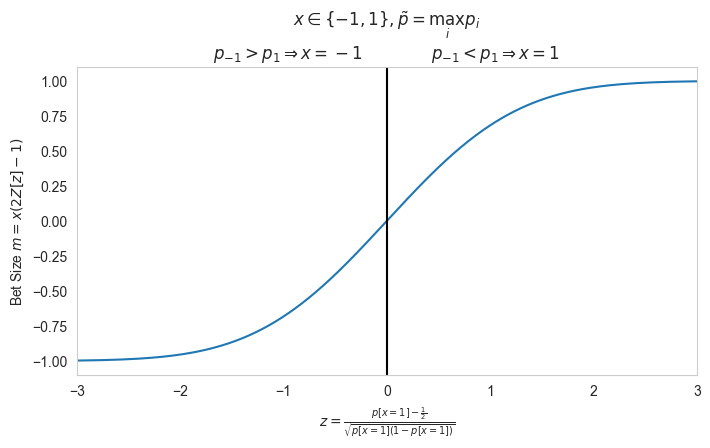

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

p_x1 = np.linspace(0, 1, 500)
eps = 1e-10
p_x1 = np.clip(p_x1, eps, 1 - eps)
z = (2 * p_x1 - 1) / (2 * np.sqrt(p_x1 * (1 - p_x1)))
m = 2 * norm.cdf(z) - 1

plt.figure(figsize=(8, 4))
plt.plot(z, m)
plt.axvline(x=0, color='black', linestyle='-')
plt.xlabel(r'$z = \frac{p[x = 1]  -\frac{1}{2}}{\sqrt{p[x=1](1 - p[x=1])}}$')
plt.xlim([-3, 3])
plt.grid(False)
plt.ylabel(r'Bet Size $m = x(2Z[z] - 1)$')
plt.title(r'$x \in \{-1, 1\}, \tilde{p} = \max_i p_i$' + '\n' + r'$p_{-1} > p_1 \Rightarrow x = -1$' + '\t' + '\t' + r'$p_{-1} < p_1 \Rightarrow x = 1$')

plt.show()

In [2]:
from FinancialMachineLearning.labeling.labeling import *

triple_barrier_event = pd.read_parquet('../../Data/AAPL_triple_barrier_events.parquet')
avg_uniqueness = pd.read_parquet('../../Data/AAPL_avg_unique.parquet')
feature_matrix = pd.read_parquet('../../Data/AAPL_feature_matrix.parquet')

labels = meta_labeling(
    triple_barrier_event, 
    feature_matrix['Close']
)
triple_barrier_event['side'] = labels['bin']
meta_labels = meta_labeling(
    triple_barrier_event, # with side labels
    feature_matrix['Close']
)

In [3]:
feature_matrix['side'] = triple_barrier_event['side'].copy()
feature_matrix['label'] = meta_labels['bin'].copy()
feature_matrix.drop(['Open','High','Low','Close','Adj Close','Volume'], axis = 1, inplace = True)
feature_matrix.dropna(inplace = True)
matrix = feature_matrix[feature_matrix['side'] != 0]

X = matrix.drop(['side','label'], axis = 1)
y = matrix['label']

X_train, X_test = X.loc[:'2019'], X.loc['2020':]
y_train, y_test = y.loc[:'2019'], y.loc['2020':]

samples_info_sets = triple_barrier_event.loc[X_train.index].loc[:'2019', 't1']

In [4]:
from sklearn.ensemble import RandomForestClassifier
from FinancialMachineLearning.sample_weights.bootstrapping import *

class SequentialRandomForestClassifier(RandomForestClassifier):
    def _generate_sample_indices(self, random_state, n_samples):
        """Generate bootstrap sample indices with sequential bootstrap method."""
        random_instance = random_state  # get the RandomState instance
        
        ind_mat = get_indicator_matrix(
            triple_barrier_event.index.to_series(),
            triple_barrier_event['t1']
        )
        
        sample_indices = seq_bootstrap(ind_mat, n_samples)
        
        return sample_indices

In [5]:
forest = SequentialRandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    random_state = 42,
    n_estimators = 100,
    max_features = 3, # early stopping
    min_weight_fraction_leaf = 0.05, # early stopping
    oob_score = True
)

forest_fit = forest.fit(
    X = X_train, 
    y = y_train, 
    sample_weight = avg_uniqueness.loc[X_train.index].to_numpy().reshape(1, -1)[0]
)

In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

y_prob = forest_fit.predict_proba(X_test)[:, 1]
y_pred = forest_fit.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8641810918774967


In [21]:
from FinancialMachineLearning.bet_sizing.bet_sizing import bet_size_probability

prob_bet = bet_size_probability(
    events = triple_barrier_event.loc['2020':],
    prob = pd.Series(y_prob, index = y_test.index),
    num_classes = 2,
    pred = None, 
    step_size = 0.0, 
    average_active = False, 
    num_threads = 8
)

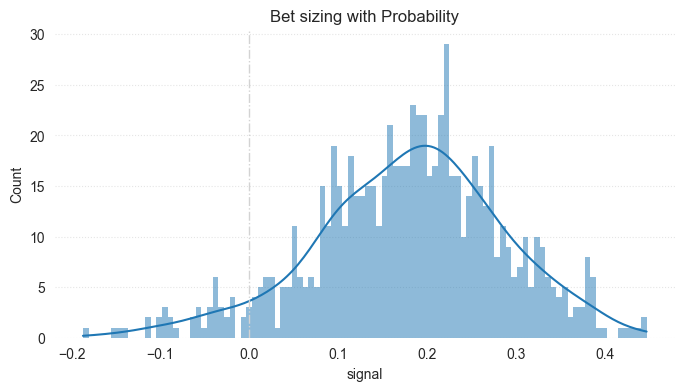

In [27]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.histplot(
    prob_bet, 
    ax = ax, 
    edgecolor = 'none', 
    kde = True,
    bins = 100
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.axvline(x = 0, color = 'lightgray', linestyle = '-.', lw = 1)
plt.title('Bet sizing with Probability')
plt.show()

검정 통계량 $z = \frac{\tilde{p} - \frac{1}{\Vert X \Vert}}{\sqrt{\tilde{p}(1-\tilde{p})}} \sim Z$를 계산한다. $z[0, +\infty)$에서 베팅 크기를 $m = x(2Z[z] - 1) \in [0,1]$로 유도하는데, 여기서 $m \in [-1, 1]$이고, $Z[z]$는 예측 $x$에 대한 크기를 조절한다. 위 그림은 베팅 크기를 검정 통계량의 함수로 나타낸 것이다. 아래의 코드는 확률을 베팅 크기로 변환하는 것을 구현하고 있다. 이 코드는 예측이 표준 labeling 추정기는 물론 meta labeling추정기로부터 나올 가능성도 함께 다루고 있다.  

### Bet Sizing by Expected Sharpe Ratio

$p$와 투자 기회가 이익 $\pi$를 산출할 것으로 예상되는 확률이고, $1 - p$는 투자 기회가 어떤 크기 $\pi > 0$의 대칭적 보상으로 이익 $- \pi$을 산출하리라는 기대 확률이다. 투자 기회로부터의 기대 이익은 $\mu = p\pi - (1 - p)(-\pi) = \pi(2p-1)$이다. 투자 기회로부터의 기대 분산은 $\sigma^2 = 4\pi^2 p(1-p)$이다. 투자 기회에 관련된 Sharpe Ratio는 다음과 같이 추정할 수 있다.

$$z = \frac{\mu}{\sigma} = \frac{p - \frac{1}{2}}{\sqrt{p(1-p)}}$$

여기서 $z \in (-\infty, +\infty)$이다. 투자 기회의 Sharpe Ratio가 표준 Gaussian 분포를 따른다고 가정할 때 우리는 베팅 크기를 $m = 2Z[z] - 1$로 도출할 수 있다. 여기서 $Z[.]$는 표준 Gaussian 분포의 누적 분포 함수로서 $m \in [-1, 1]$은 Uniform 분포를 따른다.

In [8]:
from FinancialMachineLearning.bet_sizing.bet_sizing import get_gaussian_betsize

signals = get_gaussian_betsize(y_prob)

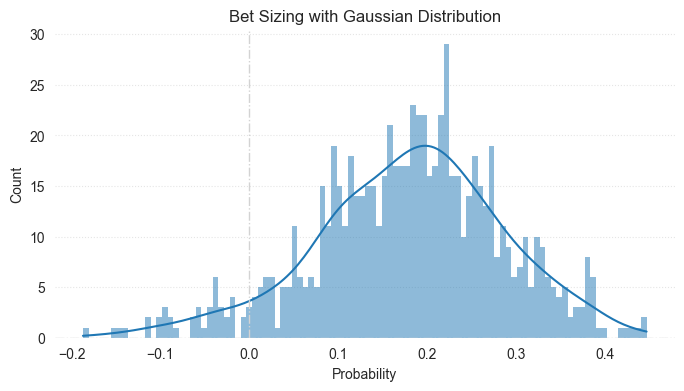

In [15]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.histplot(signals, bins = 100, kde = True, edgecolor = 'none', ax = ax)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.axvline(x = 0, color = 'lightgray', linestyle = '-.', lw = 1)
plt.axhline(y = 0, color = 'lightgray', linestyle = '-.', lw = 1)
plt.title('Bet Sizing with Gaussian Distribution')
plt.xlabel('Probability')
plt.show()

### Ensemble Bet Sizing

투자 기회가 수익성이 있는지 여부에 대한 이진 예측을 하는 n개의 Meta Labeling 분류기, 즉 $y_i = \{0, 1\}, i = 1, \dots, n$를 고려하자. 수익성이 있는 참 확률은 $p$이고, 예측 $y_i$는 Bernoulli 분포에서 추출된다. 즉 $\sum_{i=1}^n y_i \sim B[n,p]$이며, 여기서 $B[n,p]$는 확률 $p$로 $n$번 시행하는 이항 분포이다. 예측이 독립적이고 동일하게 분포된다고 가정하면 de Moivrre-Laplave 정리에 따라 $\sum_{i=1}^n y_i$의 분포는 $n$이 무한대로 커짐에 따라 평균 $np$와 분산 $np(1-p)$를 가진 Gaussian 분포로 수렴한다. 따라서 $\lim_{n \rightarrow \infty} \frac{1}{n} \sum_{i=1}^n y_i \sim N \left[p, \frac{p(1-p)}{n} \right]$이며, 이는 Lindeberg-Levy Theorem의 특수한 경우이다.

$\hat{p}$를 $n$의 Meta Labeling 분류기의 평균 예측이라고 하자. 즉 $\hat{p} = \frac{1}{n} \sum_{i=1}^n y_i, \hat{y}$와 관련된 표준 편차는 $\sqrt{\hat{p}(1 - \hat{p}) / n}$이다. 귀무가설 $H_0 : p = \frac{1}{2}$에 따라 통계량 $t = \frac{(\hat{p} - \frac{1}{2})}{\sqrt{\hat{p}(1 - \hat{p})}} \sqrt{n}, t \in \left( -\infty, +\infty\right)$는 $n-1$ 자유도를 가진 t-student 분포를 따른다. 베팅 크기를 $m = 2 t_{n-1}[t] - 1$로 도출할 수 있다. 여기서 $t_{n-1}[.]$는 $n-1$ 자유도를 가진 t-student 누적 분포 함수이고, $m \in [-1, 1]$은 균등 분포를 따른다.

In [17]:
from FinancialMachineLearning.bet_sizing.bet_sizing import get_tstats_betsize

signals = get_tstats_betsize(y_prob, N = 10)

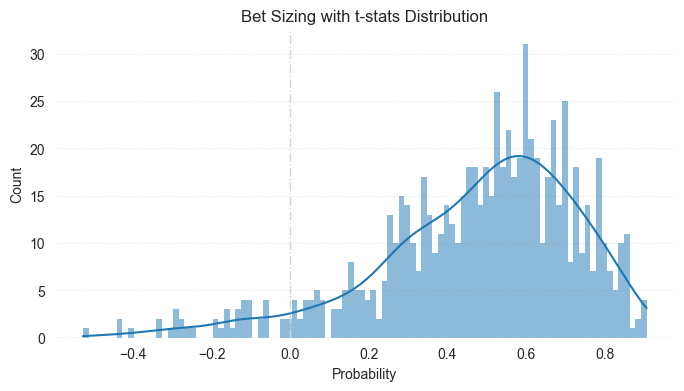

In [18]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.histplot(signals, bins = 100, kde = True, edgecolor = 'none', ax = ax)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.axvline(x = 0, color = 'lightgray', linestyle = '-.', lw = 1)
plt.axhline(y = 0, color = 'lightgray', linestyle = '-.', lw = 1)
plt.title('Bet Sizing with t-stats Distribution')
plt.xlabel('Probability')
plt.show()